In [1]:
#imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.stats.weightstats import ttest_ind
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.stats.api as sms
import statsmodels.api as sm

In [2]:
full_df = pd.read_csv("data/testing_data_NR.csv")
dpw_wrk_aux = pd.read_csv("data/DPW_wrk_aux.csv")
full_df = pd.merge(full_df, dpw_wrk_aux[["datetime", "no2_wrk_aux"]], on="datetime", how="left")
full_df.head()

,Unnamed: 0,local_timestamp,epoch,datetime,node_file_id,no2_aux,o3_wrk_aux,no_wrk_aux,temp,rh,node_id,datetime_utc,true_no2,no2_wrk_aux
0,0,2024-12-16 00:00:00,1.734336e+09,2024-12-16 08:00:00,5293194,0.32365,0.00194,0.02246,NaN,NaN,276,2024-12-16 08:00:00,20.779,-0.00530
1,1,2024-12-16 00:01:00,1.734336e+09,2024-12-16 08:01:00,5293194,0.32384,0.00265,0.02224,6.49000,44.48500,276,2024-12-16 08:01:00,19.832,-0.00566
2,2,2024-12-16 00:02:00,1.734336e+09,2024-12-16 08:02:00,5293194,NaN,NaN,NaN,NaN,NaN,276,2024-12-16 08:02:00,19.827,NaN
3,3,2024-12-16 00:03:00,1.734336e+09,2024-12-16 08:03:00,5293194,0.32328,0.00247,0.02145,6.49917,44.48120,276,2024-12-16 08:03:00,17.530,-0.00518
4,4,2024-12-16 00:04:00,1.734336e+09,2024-12-16 08:04:00,5293194,0.32330,0.00273,0.02146,6.49615,44.38477,276,2024-12-16 08:04:00,19.350,-0.00512


In [3]:
#checking we aren't missing a lot of time values
full_df["datetime_utc"] = pd.to_datetime(full_df["datetime_utc"])

full_range = pd.date_range(start=full_df["datetime_utc"].min(), end=full_df["datetime_utc"].max(), freq="min")

missing = full_range.difference(full_df['datetime_utc'])

print(f"Total expected minutes: {len(full_range)}")
print(f"Actual minutes in data: {full_df['datetime_utc'].nunique()}")
print(f"Missing minutes: {len(missing)}")

print(missing)
if not missing.empty:
    print("Example missing times:")
    print(missing[:10])


Total expected minutes: 195360
Actual minutes in data: 184470
Missing minutes: 10890
DatetimeIndex(['2024-12-16 11:39:00', '2024-12-16 13:59:00',
               '2024-12-16 16:28:00', '2024-12-16 16:29:00',
               '2024-12-17 02:59:00', '2024-12-17 05:59:00',
               '2024-12-17 16:27:00', '2024-12-18 16:27:00',
               '2024-12-22 10:59:00', '2024-12-22 14:59:00',
               ...
               '2025-04-26 13:50:00', '2025-04-26 13:51:00',
               '2025-04-26 13:52:00', '2025-04-26 13:53:00',
               '2025-04-26 13:54:00', '2025-04-26 13:55:00',
               '2025-04-26 13:56:00', '2025-04-26 13:57:00',
               '2025-04-26 13:58:00', '2025-04-26 13:59:00'],
              dtype='datetime64[ns]', length=10890, freq=None)
Example missing times:
DatetimeIndex(['2024-12-16 11:39:00', '2024-12-16 13:59:00',
               '2024-12-16 16:28:00', '2024-12-16 16:29:00',
               '2024-12-17 02:59:00', '2024-12-17 05:59:00',
               '

In [4]:
full_df = full_df.sort_values("datetime_utc")

full_df["rh"] = full_df["rh"].interpolate(method="linear", limit_direction="both")
full_df["temp"] = full_df["temp"].interpolate(method="linear", limit_direction="both")

In [5]:
window_size = 10 #in minutes
full_df["no2_rolling_std"] = full_df["true_no2"].rolling(window=window_size, min_periods=5).std()

std_threshold = 0.01
full_df["flatline_flag"] = full_df["no2_rolling_std"] < std_threshold
full_df.to_csv("full_df_wf.csv", index=False)

In [6]:
full_df["flatline_flag"].value_counts()

flatline_flag
False    176204
True       8266
Name: count, dtype: int64

In [7]:
#remove the flatline data
full_df = full_df[full_df["flatline_flag"] == False]

In [8]:
#identify low RSD times to create training data
low_rsd_df = pd.read_csv("data/low_rsd.csv")

In [9]:
full_df["datetime_utc"] = pd.to_datetime(full_df["datetime_utc"])
low_rsd_df["datetime"] = pd.to_datetime(low_rsd_df["datetime"])

low_rsd_hours = set(low_rsd_df["datetime"])
full_df["hour"] = full_df["datetime_utc"].dt.floor("h")
full_df["hour_of_day"] = full_df["datetime_utc"].dt.hour 

training_df = full_df[full_df["hour"].isin(low_rsd_hours)].copy()
training_df.head()


,Unnamed: 0,local_timestamp,epoch,datetime,node_file_id,no2_aux,o3_wrk_aux,no_wrk_aux,temp,rh,node_id,datetime_utc,true_no2,no2_wrk_aux,no2_rolling_std,flatline_flag,hour,hour_of_day
3472,3472,2024-12-18 10:00:00,1.734545e+09,2024-12-18 18:00:00,5301721,0.32343,-0.00027,0.03406,23.38692,21.63169,276,2024-12-18 18:00:00,7.245,-0.01295,2.925069,False,2024-12-18 18:00:00,18
3473,3473,2024-12-18 10:01:00,1.734545e+09,2024-12-18 18:01:00,5301721,0.32312,-0.00087,0.03627,23.39000,21.65820,276,2024-12-18 18:01:00,11.384,-0.01257,3.086940,False,2024-12-18 18:00:00,18
3474,3474,2024-12-18 10:02:00,1.734545e+09,2024-12-18 18:02:00,5301721,0.32289,-0.00071,0.02947,23.38538,21.67999,276,2024-12-18 18:02:00,10.368,-0.01409,2.957236,False,2024-12-18 18:00:00,18
3475,3475,2024-12-18 10:03:00,1.734545e+09,2024-12-18 18:03:00,5301721,0.32371,-0.00167,0.04499,23.38143,21.69692,276,2024-12-18 18:03:00,5.477,-0.01375,2.957199,False,2024-12-18 18:00:00,18
3476,3476,2024-12-18 10:04:00,1.734545e+09,2024-12-18 18:04:00,5301721,0.32354,-0.00047,0.03070,23.38000,21.72531,276,2024-12-18 18:04:00,11.521,-0.01211,2.777037,False,2024-12-18 18:00:00,18


In [10]:
from sklearn.linear_model import LinearRegression

training_df["datetime_utc"] = pd.to_datetime(training_df["datetime_utc"])

training_df["month"] = training_df["datetime_utc"].dt.to_period("M")

features = ["no2_aux", "o3_wrk_aux", "no_wrk_aux", "temp", "rh", "no2_wrk_aux", "hour_of_day"]
target = "true_no2"

coefficients_by_month = []

for month, group in training_df.groupby('month'):
    group = group.dropna(subset=features + [target])
    
    if len(group) < len(features) + 1:
        continue 
    
    X = group[features]
    y = group[target]
    
    model = LinearRegression()
    model.fit(X, y)
    
    coef_dict = {
        'month': str(month),
        'intercept': model.intercept_
    }
    for f, coef in zip(features, model.coef_):
        coef_dict[f] = coef
        
    coefficients_by_month.append(coef_dict)

monthly_coefs_df = pd.DataFrame(coefficients_by_month)

print(monthly_coefs_df.head())


     month   intercept      no2_aux  o3_wrk_aux  no_wrk_aux      temp  \
0  2024-12 -374.920786  1280.364386 -485.541232    4.099337  0.080600   
1  2025-01    6.972142    12.820833 -318.483270  323.616019 -0.534535   
2  2025-02  -98.427485   318.756294  -37.881644  299.705423 -0.470327   
3  2025-03  101.956938  -231.718151   59.306232  286.629256 -0.813944   
4  2025-04 -295.001215   969.646510  315.372881  270.301748 -0.529559   

         rh  no2_wrk_aux  hour_of_day  
0 -0.237815  2000.705126     0.075298  
1  0.143286    21.985602    -0.079102  
2  0.240811    13.243663     0.105962  
3 -0.047658     6.947014    -0.429618  
4 -0.006077    22.822904    -0.013463  


Pearson R²: -0.0663


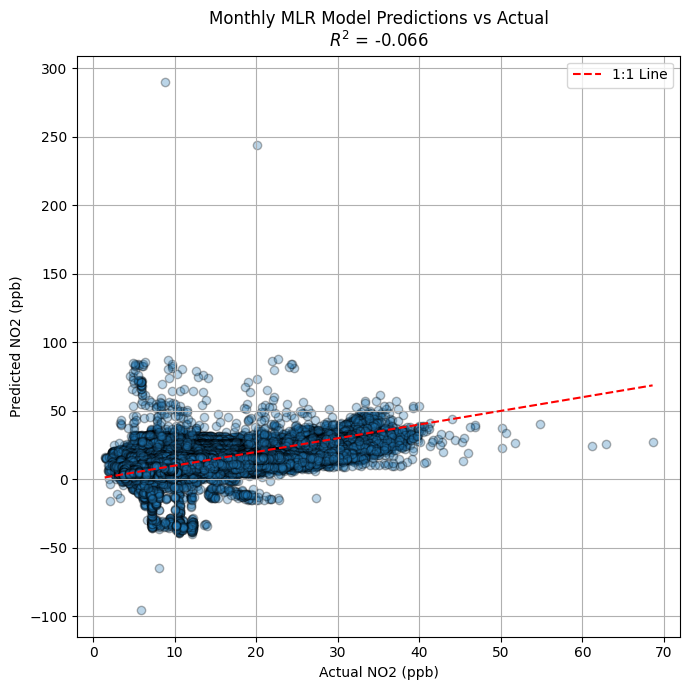

In [11]:
from sklearn.metrics import r2_score

full_df["datetime_utc"] = pd.to_datetime(full_df["datetime_utc"])
full_df["month"] = full_df["datetime_utc"].dt.to_period("M")


features = ["no2_aux", "o3_wrk_aux", "no_wrk_aux", "temp", "rh", "no2_wrk_aux", "hour_of_day"]
full_df = full_df.dropna(subset=features + ["true_no2"])

full_df["predicted_no2"] = np.nan

model_dict = {
    row["month"]: {
        "intercept": row["intercept"],
        "coefs": [row[f] for f in features]
    }
    for _, row in monthly_coefs_df.iterrows()
}

for month, group in full_df.groupby('month'):
    if str(month) not in model_dict:
        continue

    model = model_dict[str(month)]
    X = group[features].values
    preds = np.dot(X, model["coefs"]) + model["intercept"]
    full_df.loc[group.index, "predicted_no2"] = preds

valid_df = full_df.dropna(subset=["predicted_no2", "true_no2"])

r2 = r2_score(valid_df["true_no2"], valid_df["predicted_no2"])
print(f"Pearson R²: {r2:.4f}")


plt.figure(figsize=(7, 7))
plt.scatter(valid_df["true_no2"], valid_df["predicted_no2"], alpha=0.3, edgecolor="k")
plt.plot([valid_df["true_no2"].min(), valid_df["true_no2"].max()],
         [valid_df["true_no2"].min(), valid_df["true_no2"].max()],
         color="red", linestyle="--", label="1:1 Line")
plt.xlabel("Actual NO2 (ppb)")
plt.ylabel("Predicted NO2 (ppb)")
plt.title(f'Monthly MLR Model Predictions vs Actual\n$R^2$ = {r2:.3f}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Pearson R²: 0.0477


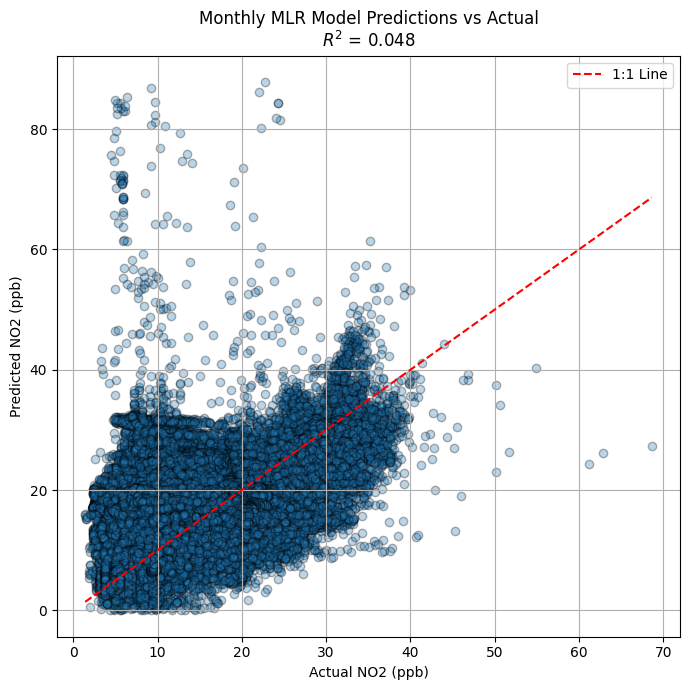

In [12]:
valid_df = valid_df[(valid_df["predicted_no2"] >= 0) & (valid_df["predicted_no2"] <= 150)]
r2 = r2_score(valid_df["true_no2"], valid_df["predicted_no2"])
print(f"Pearson R²: {r2:.4f}")


plt.figure(figsize=(7, 7))
plt.scatter(valid_df["true_no2"], valid_df["predicted_no2"], alpha=0.3, edgecolor="k")
plt.plot([valid_df["true_no2"].min(), valid_df["true_no2"].max()],
         [valid_df["true_no2"].min(), valid_df["true_no2"].max()],
         color="red", linestyle="--", label="1:1 Line")
plt.xlabel("Actual NO2 (ppb)")
plt.ylabel("Predicted NO2 (ppb)")
plt.title(f'Monthly MLR Model Predictions vs Actual\n$R^2$ = {r2:.3f}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import pandas as pd

training_df["datetime_utc"] = pd.to_datetime(training_df["datetime_utc"])
training_df["month"] = training_df["datetime_utc"].dt.to_period("M")

features = ["no2_aux", "o3_wrk_aux", "no_wrk_aux", "temp", "rh", "no2_wrk_aux", "hour_of_day"]
target = "true_no2"

poly = PolynomialFeatures(degree=2, include_bias=False)
coefficients_by_month = []

for month, group in training_df.groupby('month'):
    group = group.dropna(subset=features + [target])
    
    if len(group) < len(features) + 1:
        continue

    X = group[features]
    y = group[target]

    X_poly = poly.fit_transform(X)

    model = LinearRegression()
    model.fit(X_poly, y)

    poly_feature_names = poly.get_feature_names_out(features)

    coef_dict = {
        'month': str(month),
        'intercept': model.intercept_
    }
    for f, coef in zip(poly_feature_names, model.coef_):
        coef_dict[f] = coef

    coefficients_by_month.append(coef_dict)

monthly_coefs_df = pd.DataFrame(coefficients_by_month)


Polynomial Regression R²: -1384.0660


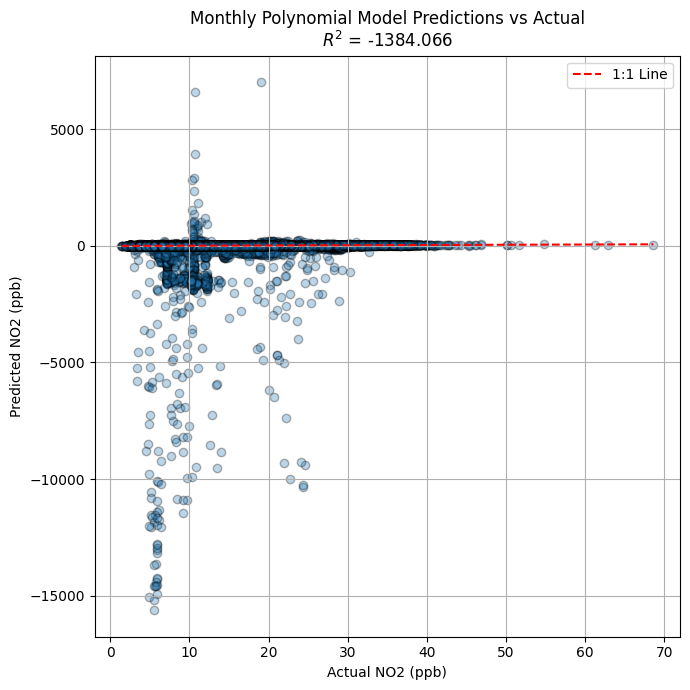

In [14]:
poly = PolynomialFeatures(degree=2, include_bias=False)
features = ["no2_aux", "o3_wrk_aux", "no_wrk_aux", "temp", "rh", "no2_wrk_aux", "hour_of_day"]

full_df["datetime_utc"] = pd.to_datetime(full_df["datetime_utc"])
full_df["month"] = full_df["datetime_utc"].dt.to_period("M")
full_df = full_df.dropna(subset=features + ["true_no2"])
full_df["predicted_no2"] = np.nan

X_sample = full_df[features].iloc[:1]
poly_feature_names = poly.fit(X_sample).get_feature_names_out(features)

model_dict = {
    row["month"]: {
        "intercept": row["intercept"],
        "coefs": np.array([row.get(f, 0.0) for f in poly_feature_names])
    }
    for _, row in monthly_coefs_df.iterrows()
}

for month, group in full_df.groupby('month'):
    if str(month) not in model_dict:
        continue

    model = model_dict[str(month)]
    X = group[features]
    X_poly = poly.fit_transform(X)
    preds = np.dot(X_poly, model["coefs"]) + model["intercept"]
    full_df.loc[group.index, "predicted_no2"] = preds

valid_df = full_df.dropna(subset=["predicted_no2", "true_no2"])
r2 = r2_score(valid_df["true_no2"], valid_df["predicted_no2"])
print(f"Polynomial Regression R²: {r2:.4f}")

plt.figure(figsize=(7, 7))
plt.scatter(valid_df["true_no2"], valid_df["predicted_no2"], alpha=0.3, edgecolor="k")
plt.plot([valid_df["true_no2"].min(), valid_df["true_no2"].max()],
         [valid_df["true_no2"].min(), valid_df["true_no2"].max()],
         color="red", linestyle="--", label="1:1 Line")
plt.xlabel("Actual NO2 (ppb)")
plt.ylabel("Predicted NO2 (ppb)")
plt.title(f'Monthly Polynomial Model Predictions vs Actual\n$R^2$ = {r2:.3f}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Pearson R²: 0.1043


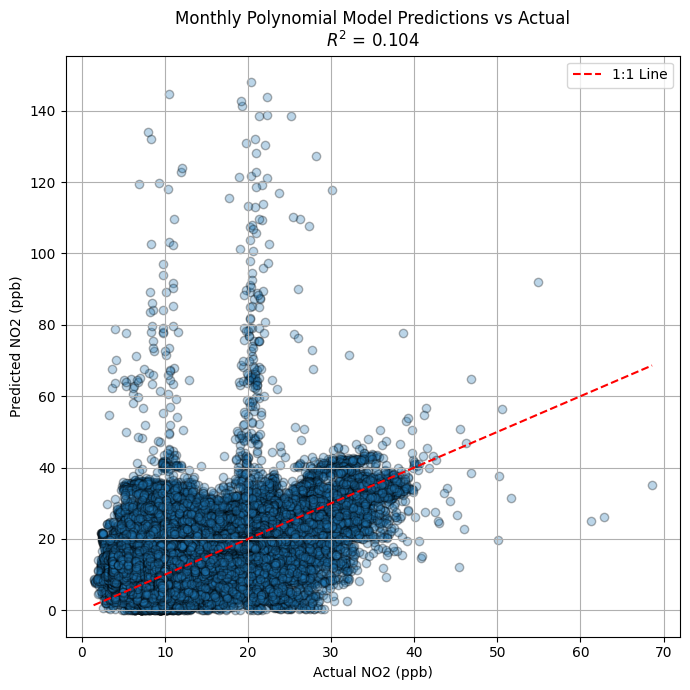

In [15]:
valid_df = valid_df[(valid_df["predicted_no2"] >= 0) & (valid_df["predicted_no2"] <= 150)]
r2 = r2_score(valid_df["true_no2"], valid_df["predicted_no2"])
print(f"Pearson R²: {r2:.4f}")


plt.figure(figsize=(7, 7))
plt.scatter(valid_df["true_no2"], valid_df["predicted_no2"], alpha=0.3, edgecolor="k")
plt.plot([valid_df["true_no2"].min(), valid_df["true_no2"].max()],
         [valid_df["true_no2"].min(), valid_df["true_no2"].max()],
         color="red", linestyle="--", label="1:1 Line")
plt.xlabel("Actual NO2 (ppb)")
plt.ylabel("Predicted NO2 (ppb)")
plt.title(f'Monthly Polynomial Model Predictions vs Actual\n$R^2$ = {r2:.3f}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [16]:
from sklearn.ensemble import RandomForestRegressor

training_df["datetime_utc"] = pd.to_datetime(training_df["datetime_utc"])
training_df["month"] = training_df["datetime_utc"].dt.to_period("M")

features = ["no2_aux", "o3_wrk_aux", "no_wrk_aux", "temp", "rh", "no2_wrk_aux", "hour_of_day"]
target = "true_no2"

rf_models_by_month = []
feature_importances_by_month = []

for month, group in training_df.groupby('month'):
    group = group.dropna(subset=features + [target])
    
    if len(group) < 50:
        continue
    
    X = group[features]
    y = group[target]
    
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X, y)

    rf_models_by_month.append({
        "month": str(month),
        "model": model
    })
    
    importance_record = {"month": str(month)}
    for f, imp in zip(features, model.feature_importances_):
        importance_record[f] = imp
    feature_importances_by_month.append(importance_record)

feature_importance_df = pd.DataFrame(feature_importances_by_month)

print(feature_importance_df.head())


     month   no2_aux  o3_wrk_aux  no_wrk_aux      temp        rh  no2_wrk_aux  \
0  2024-12  0.005627    0.027733    0.011026  0.694738  0.013102     0.238219   
1  2025-01  0.008072    0.045693    0.016688  0.015197  0.708895     0.195080   
2  2025-02  0.035370    0.070239    0.189465  0.093970  0.490742     0.093244   
3  2025-03  0.013029    0.022184    0.128290  0.034903  0.225497     0.521609   
4  2025-04  0.029105    0.067897    0.085828  0.481420  0.233972     0.086034   

   hour_of_day  
0     0.009555  
1     0.010375  
2     0.026970  
3     0.054489  
4     0.015744  


Random Forest R²: 0.3306


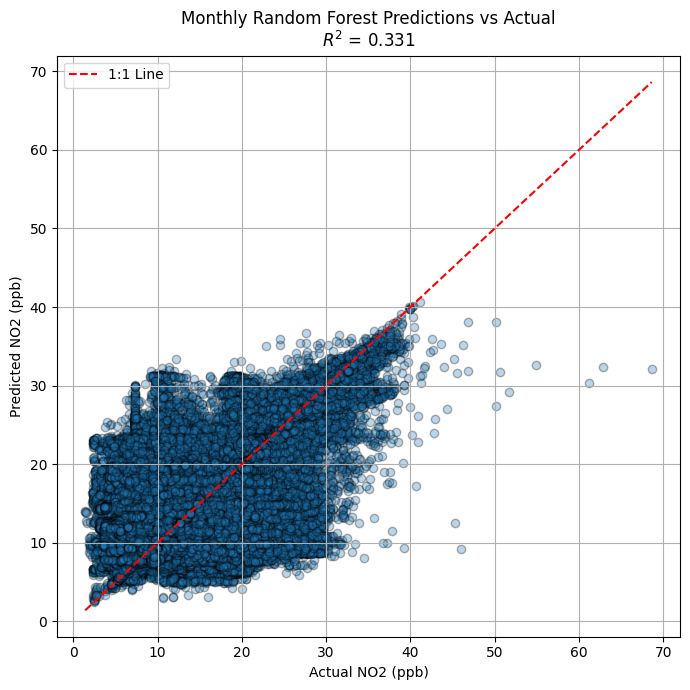

In [17]:
full_df["datetime_utc"] = pd.to_datetime(full_df["datetime_utc"])
full_df["month"] = full_df["datetime_utc"].dt.to_period("M")

features = ["no2_aux", "o3_wrk_aux", "no_wrk_aux", "temp", "rh", "no2_wrk_aux", "hour_of_day"]
full_df = full_df.dropna(subset=features + ["true_no2"])
full_df["predicted_no2"] = np.nan

rf_model_dict = {
    entry["month"]: entry["model"]
    for entry in rf_models_by_month
}

for month, group in full_df.groupby("month"):
    if str(month) not in rf_model_dict:
        continue

    model = rf_model_dict[str(month)]
    X = group[features]
    preds = model.predict(X)
    full_df.loc[group.index, "predicted_no2"] = preds

valid_df = full_df.dropna(subset=["predicted_no2", "true_no2"])

r2 = r2_score(valid_df["true_no2"], valid_df["predicted_no2"])
print(f"Random Forest R²: {r2:.4f}")

plt.figure(figsize=(7, 7))
plt.scatter(valid_df["true_no2"], valid_df["predicted_no2"], alpha=0.3, edgecolor="k")
plt.plot(
    [valid_df["true_no2"].min(), valid_df["true_no2"].max()],
    [valid_df["true_no2"].min(), valid_df["true_no2"].max()],
    color="red", linestyle="--", label="1:1 Line"
)
plt.xlabel("Actual NO2 (ppb)")
plt.ylabel("Predicted NO2 (ppb)")
plt.title(f'Monthly Random Forest Predictions vs Actual\n$R^2$ = {r2:.3f}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [18]:
import xgboost as xgb
training_df["datetime_utc"] = pd.to_datetime(training_df["datetime_utc"])
training_df["month"] = training_df["datetime_utc"].dt.to_period("M")

features = ["no2_aux", "o3_wrk_aux", "no_wrk_aux", "temp", "rh", "no2_wrk_aux", "hour_of_day"]
target = "true_no2"

xgb_models_by_month = []
xgb_importances_by_month = []

for month, group in training_df.groupby('month'):
    group = group.dropna(subset=features + [target])
    
    if len(group) < 50:
        continue
    
    X = group[features]
    y = group[target]
    
    model = xgb.XGBRegressor(
        n_estimators=100,
        max_depth=4,
        learning_rate=0.1,
        objective='reg:squarederror',
        random_state=42,
        verbosity=0
    )
    
    model.fit(X, y)
    
    xgb_models_by_month.append({
        "month": str(month),
        "model": model
    })
    
    importance_record = {"month": str(month)}
    for f, imp in zip(features, model.feature_importances_):
        importance_record[f] = imp
    xgb_importances_by_month.append(importance_record)

xgb_importance_df = pd.DataFrame(xgb_importances_by_month)

print(xgb_importance_df.head())


     month   no2_aux  o3_wrk_aux  no_wrk_aux      temp        rh  no2_wrk_aux  \
0  2024-12  0.005210    0.022846    0.015376  0.707563  0.008366     0.221161   
1  2025-01  0.010911    0.045965    0.032881  0.019809  0.633274     0.219629   
2  2025-02  0.029754    0.055985    0.185866  0.088997  0.481311     0.093537   
3  2025-03  0.011817    0.050456    0.109352  0.050413  0.264218     0.329808   
4  2025-04  0.107849    0.068332    0.097157  0.443529  0.129848     0.088559   

   hour_of_day  
0     0.019478  
1     0.037532  
2     0.064549  
3     0.183935  
4     0.064725  


XGBoost Monthly Model R²: 0.3846


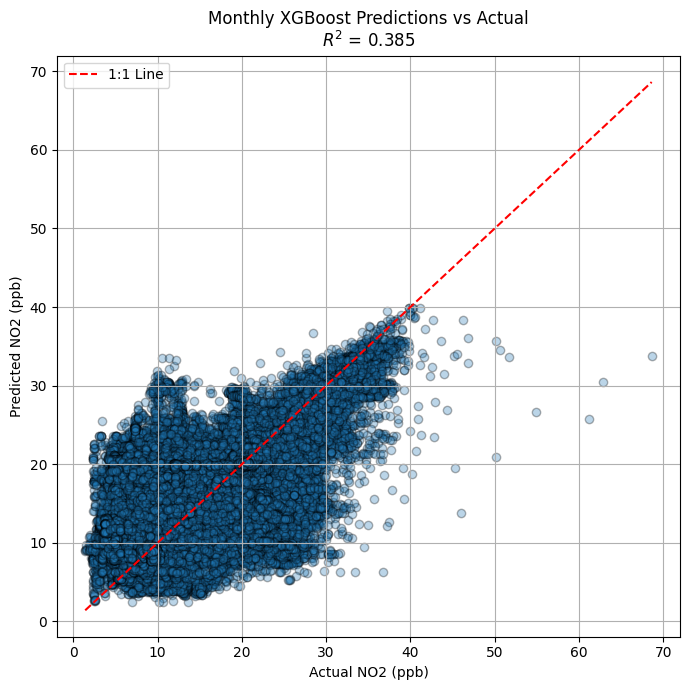

In [19]:
full_df["datetime_utc"] = pd.to_datetime(full_df["datetime_utc"])
full_df["month"] = full_df["datetime_utc"].dt.to_period("M")

features = ["no2_aux", "o3_wrk_aux", "no_wrk_aux", "temp", "rh", "no2_wrk_aux", "hour_of_day"]
full_df = full_df.dropna(subset=features + ["true_no2"])
full_df["predicted_no2"] = np.nan

xgb_model_dict = {
    entry["month"]: entry["model"]
    for entry in xgb_models_by_month
}

for month, group in full_df.groupby("month"):
    if str(month) not in xgb_model_dict:
        continue

    model = xgb_model_dict[str(month)]
    X = group[features]
    preds = model.predict(X)
    full_df.loc[group.index, "predicted_no2"] = preds

valid_df = full_df.dropna(subset=["predicted_no2", "true_no2"])
r2 = r2_score(valid_df["true_no2"], valid_df["predicted_no2"])
print(f"XGBoost Monthly Model R²: {r2:.4f}")

plt.figure(figsize=(7, 7))
plt.scatter(valid_df["true_no2"], valid_df["predicted_no2"], alpha=0.3, edgecolor="k")
plt.plot(
    [valid_df["true_no2"].min(), valid_df["true_no2"].max()],
    [valid_df["true_no2"].min(), valid_df["true_no2"].max()],
    color="red", linestyle="--", label="1:1 Line"
)
plt.xlabel("Actual NO2 (ppb)")
plt.ylabel("Predicted NO2 (ppb)")
plt.title(f'Monthly XGBoost Predictions vs Actual\n$R^2$ = {r2:.3f}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
